# Disease Tagging Tutorial

In this example, we'll be writing an application to extract *mentions of* diseases from Pubmed abstracts, using annotations from the [BioCreative CDR Challenge](http://www.biocreative.org/resources/corpora/biocreative-v-cdr-corpus/).  This tutorial, which has 5 parts, walks through the process of constructing a model to classify _candidate_ disease mentions as either true (i.e., that it is truly a mention of a disease) or false.

## Part IV: Training a Model with Data Programming

In this part of the tutorial, we will train a statistical model to differentiate between true and false `Disease` mentions.

We will train this model using _data programming_, and we will **ignore** the training labels provided with the training data. This is a more realistic scenario; in the wild, hand-labeled training data is rare and expensive. Data programming enables us to train a model using only a modest amount of hand-labeled data for validation and testing. For more information on data programming, see the [NIPS 2016 paper](https://arxiv.org/abs/1605.07723).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We repeat our definition of the `Disease` `Candidate` subclass from Parts II and III.

In [2]:
from snorkel.models import candidate_subclass

Disease = candidate_subclass('Disease', ['disease'])

## Loading `CandidateSet` objects

We reload the training and development `CandidateSet` objects from the previous parts of the tutorial.

In [3]:
from snorkel.models import CandidateSet

train = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Training Candidates').one()
dev = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Development Candidates').one()

## Automatically Creating Features
Recall that our goal is to distinguish between true and false mentions of chemical-disease relations. To train a model for this task, we first embed our `ChemicalDisease` candidates in a feature space.

In [4]:
from snorkel.annotations import FeatureManager

feature_manager = FeatureManager()

We can create a new feature set:

In [5]:
%time F_train = feature_manager.create(session, train, 'Train Features')

[========================================] 100%

Loading sparse Feature matrix...
CPU times: user 6min 49s, sys: 9.87 s, total: 6min 59s
Wall time: 7min 17s


**OR** if we've already created one, we can simply load as follows:

In [6]:
%time F_train = feature_manager.load(session, train, 'Train Features')

CPU times: user 4.48 s, sys: 146 ms, total: 4.63 s
Wall time: 4.78 s


Note that the returned matrix is a special subclass of the `scipy.sparse.csr_matrix` class, with some special features which we demonstrate below:

In [7]:
F_train

<5981x124721 sparse matrix of type '<type 'numpy.float64'>'
	with 290691 stored elements in Compressed Sparse Row format>

In [8]:
F_train.get_candidate(0)

Disease(Span("acute renal failure", parent=5043, chars=[83,101], words=[16,18]))

In [9]:
F_train.get_key(0)

AnnotationKey (DDL_WORD_SEQ_[acute renal failure])

## Creating Labeling Functions
Labeling functions are a core tool of data programming. They are heuristic functions that aim to classify candidates correctly. Their outputs will be automatically combined and denoised to estimate the probabilities of training labels for the training data.

In [10]:
import re
from lf_terms import *
from snorkel.lf_helpers import get_left_tokens, get_right_tokens

We also load some publicly-available biomedical dictionaries, which we will leverage in some of our LFs below as a source of weak supervision:

In [11]:
from utils import *

umls_dict              = load_umls_dictionary()
chemicals              = load_chemdner_dictionary()
abbrv2text, text2abbrv = load_specialist_abbreviations()

#### Document-Level Labeling Functions
We start with some labeling functions that label candidates based on document-level features.

In [12]:
from snorkel.lf_helpers import get_doc_candidate_spans

def LF_undefined_abbreviation(c):
    '''Candidate is a known abbreviation, but no corresponding full name in document'''
    doc_spans = get_doc_candidate_spans(c)
    phrase = c[0].get_span().lower()
    mentions = set([s.get_span().lower() for s in doc_spans])
    if len(phrase) > 1 and phrase in abbrv2text and not set(abbrv2text[phrase].keys()).intersection(mentions):
        return -1
    return 0

#### Sentence-Level Labeling Functions
We also include some labeling functions that label candidates based on sentence-level features.

In [13]:
from snorkel.lf_helpers import get_sent_candidate_spans

def LF_contiguous_mentions(c):
    '''Contiguous candidates are likely wrong'''
    neighbor_spans = get_sent_candidate_spans(c)
    start, end = c[0].get_word_start(), c[0].get_word_end()
    for s in neighbor_spans:
        if s.get_word_end() + 1 == start or s.get_word_start() - 1 == end:
            return -1
    return 0

#### Mention-Level Labeling Functions
We now define a number of labeling functions that label candidates based on attributes related to the mention.

In [14]:
from snorkel.lf_helpers import get_left_tokens, get_right_tokens

def LF_tumors_growths(c):
    phrase = " ".join(c[0].get_attrib_tokens('lemmas'))
    return 1 if re.search("^(\w* ){0,2}(['] )*(tumor|tumour|polyp|pilomatricoma|cyst|lipoma)$", phrase) else 0

def LF_cancer(c):
    '''<TYPE> cancer'''
    phrase = " ".join(c[0].get_attrib_tokens('lemmas'))
    return 1 if re.search("\w* cancer",phrase) else 0

def LF_disease_syndrome(c):
    '''<TYPE> disease or <TYPE> syndrome'''
    phrase = " ".join(c[0].get_attrib_tokens('lemmas'))
    return 1 if re.search("\w* (disease|syndrome)+",phrase) else 0

def LF_indicators(c):
    '''Indicator words'''
    return 1 if " ".join(c[0].get_attrib_tokens()).lower() in indicators else 0

def LF_common_disease(c):
    '''Common disease'''
    return 1 if " ".join(c[0].get_attrib_tokens()).lower() in common_disease else 0

*For a few more examples of LFs of this style that we'll use, see [Disease_Tagging_Tutorial_LFs.py](Disease_Tagging_Tutorial_LFs.py).*

#### Dictionary Labeling Functions
We can use existing dictionaries for distant supervision.

In [15]:
def LF_SNOWMED_CT_sign_or_symptom(c):
    return 1 if c[0].get_span() in umls_dict["snomedct"]["sign_or_symptom"] else 0

def LF_SNOWMED_CT_disease_or_syndrome(c):
    return 1 if c[0].get_span() in umls_dict["snomedct"]["disease_or_syndrome"] else 0

def LF_MESH_disease_or_syndrome(c):
    return 1 if c[0].get_span() in umls_dict["mesh"]["disease_or_syndrome"] else 0

def LF_MESH_sign_or_symptom(c):
    return 1 if c[0].get_span() in umls_dict["mesh"]["sign_or_symptom"] else 0

#### Negative Labeling Functions
When writing labeling functions, it is important to provide negative supervision in addition to positive supervision.

In [16]:
def LF_organs(c):
    phrase = " ".join(c[0].get_attrib_tokens()).lower()
    return -1 if phrase in organs else 0      

def LF_chemical_name(c):
    phrase = " ".join(c[0].get_attrib_tokens())
    return -1 if phrase in chemicals and not phrase.isupper() else 0

def LF_bodysym(c):
    phrase = " ".join(c[0].get_attrib_tokens()).lower()
    return -1 if phrase in bodysym else 0  

def LF_protein_chemical_abbrv(c):
    '''Gene/protein/chemical name'''
    lemma = " ".join(c[0].get_attrib_tokens('lemmas'))
    return -1 if re.search("\d+",lemma) else 0

def LF_base_pair_seq(c): 
    lemma = " ".join(c[0].get_attrib_tokens('lemmas'))
    return -1 if re.search("^[GACT]{2,}$",lemma) else 0

*For a few more examples of LFs of this style that we'll use, see [Disease_Tagging_Tutorial_LFs.py](Disease_Tagging_Tutorial_LFs.py).*

We maintain a list of all LFs for convenience.

In [17]:
from Disease_Tagging_Tutorial_LFs import *

LFs_doc = [LF_undefined_abbreviation]

LFs_sent = [LF_contiguous_mentions]

LFs_mention = [LF_tumors_growths,
               LF_cancer,
               LF_disease_syndrome,
               LF_indicators,
               LF_common_disease,
               LF_common_disease_acronyms,
               LF_deficiency_of,
               LF_positive_indicator,
               LF_left_positive_argument,
               LF_right_negative_argument,
               LF_medical_afixes,
               LF_adj_diseases
              ]

LFs_dicts =  [LF_SNOWMED_CT_sign_or_symptom,
              LF_SNOWMED_CT_disease_or_syndrome,
              LF_MESH_disease_or_syndrome,
              LF_MESH_sign_or_symptom
            ]

LFs_false = [LF_chemical_name,
             LF_organs,
             LF_bodysym,
             LF_protein_chemical_abbrv,
             LF_base_pair_seq,
             LF_too_vague,
             LF_neg_surfix,
             LF_non_common_disease,
             LF_non_disease_acronyms,
             LF_pos_in,
             LF_gene_chromosome_link,
             LF_right_window_incomplete,
             LF_negative_indicator
            ]

## Applying Labeling Functions

First we construct a `CandidateLabeler`.

In [18]:
from snorkel.annotations import LabelManager

label_manager = LabelManager()

Next we run the `CandidateLabeler` to to apply the labeling functions to the training `CandidateSet`.  We'll start with some of our labeling functions:

In [19]:
LFs = LFs_mention + LFs_dicts + LFs_false
%time L_train = label_manager.create(session, train, 'LF Labels', f=LFs)
L_train

[========================================] 100%

Loading sparse Label matrix...
CPU times: user 2min 59s, sys: 3.43 s, total: 3min 2s
Wall time: 3min 10s


<5981x29 sparse matrix of type '<type 'numpy.float64'>'
	with 6413 stored elements in Compressed Sparse Row format>

**OR** load if we've already created:

In [20]:
%time L_train = label_manager.load(session, train, 'LF Labels')
L_train

CPU times: user 230 ms, sys: 2.82 ms, total: 233 ms
Wall time: 232 ms


<5981x29 sparse matrix of type '<type 'numpy.float64'>'
	with 6413 stored elements in Compressed Sparse Row format>

We can also add or rerun a single labeling function (or more!) with the below command. Note that we set the argument `expand_key_set` to `True` to indicate that the set of matrix columns should be allowed to expand:

In [21]:
LFs_2   = LFs_doc + LFs_sent
L_train = label_manager.update(session, train, 'LF Labels', True, f=LFs_2)
L_train

[========================================] 100%

Loading sparse Label matrix...


<5981x31 sparse matrix of type '<type 'numpy.float64'>'
	with 6832 stored elements in Compressed Sparse Row format>

We can view statistics about the resulting label matrix:

In [22]:
L_train.lf_stats()

,conflicts,coverage,j,overlaps
LF_tumors_growths,0.000167,0.005016,0,0.005016
LF_cancer,0.000167,0.007357,1,0.000334
LF_disease_syndrome,0.000836,0.025079,2,0.018392
LF_indicators,0.000334,0.005183,3,0.003846
LF_common_disease,0.019896,0.224712,4,0.121050
LF_common_disease_acronyms,0.001839,0.018893,5,0.011871
LF_deficiency_of,0.000334,0.008360,6,0.008360
LF_positive_indicator,0.010533,0.148470,7,0.101154
LF_left_positive_argument,0.001338,0.030430,8,0.018392
LF_right_negative_argument,0.000000,0.001672,9,0.001338


## Fitting the Generative Model
We estimate the accuracies of the labeling functions without supervision. Specifically, we estimate the parameters of a `NaiveBayes` generative model.

In [23]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L_train, n_iter=3000, rate=1e-5)

Training marginals (!= 0.5):	5981
Features:			31
Begin training for rate=1e-05, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.138525
	Learning epoch = 250	Gradient mag. = 0.145826
	Learning epoch = 500	Gradient mag. = 0.145837
	Learning epoch = 750	Gradient mag. = 0.145848
	Learning epoch = 1000	Gradient mag. = 0.145859
	Learning epoch = 1250	Gradient mag. = 0.145870
	Learning epoch = 1500	Gradient mag. = 0.145881
	Learning epoch = 1750	Gradient mag. = 0.145892
	Learning epoch = 2000	Gradient mag. = 0.145903
	Learning epoch = 2250	Gradient mag. = 0.145914
	Learning epoch = 2500	Gradient mag. = 0.145925
	Learning epoch = 2750	Gradient mag. = 0.145935
Final gradient magnitude for rate=1e-05, mu=1e-06: 0.146


/Users/bradenhancock/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [24]:
gen_model.save(session, 'Generative Params')

We now apply the generative model to the training candidates.

In [25]:
train_marginals = gen_model.marginals(L_train)

## Training the Discriminative Model
We use the estimated probabilites to train a discriminative model that classifies each `Candidate` as a true or false mention.

In [26]:
from snorkel.learning import LogReg

disc_model = LogReg()
disc_model.train(F_train, train_marginals, n_iter=5000, rate=1e-3)

Training marginals (!= 0.5):	4339
Features:			124721
Using gradient descent...
	Learning epoch = 0	Step size = 0.001
	Loss = 3007.565616	Gradient magnitude = 599.975492
	Learning epoch = 100	Step size = 0.000904792147114
	Loss = 2164.744254	Gradient magnitude = 27.780400
	Learning epoch = 200	Step size = 0.000818648829479
	Loss = 2131.225536	Gradient magnitude = 13.523434
	Learning epoch = 300	Step size = 0.000740707032156
	Loss = 2122.074986	Gradient magnitude = 8.537199
	Learning epoch = 400	Step size = 0.000670185906007
	Loss = 2118.361287	Gradient magnitude = 6.110768
	Learning epoch = 500	Step size = 0.000606378944861
	Loss = 2116.510671	Gradient magnitude = 4.719493
	Learning epoch = 600	Step size = 0.000548646907485
	Loss = 2115.461462	Gradient magnitude = 3.837179
	Learning epoch = 700	Step size = 0.000496411413431
	Loss = 2114.811059	Gradient magnitude = 3.237659
	Learning epoch = 800	Step size = 0.00044914914861
	Loss = 2114.380591	Gradient magnitude = 2.809254
	Learning epoc

In [27]:
disc_model.w.shape

(124721,)

In [28]:
%time disc_model.save(session, "Discriminative Params")

CPU times: user 26.1 s, sys: 916 ms, total: 27 s
Wall time: 27.1 s


## Evaluating on the Development `CandidateSet`

First, we create features for the development set.

Note that we use the training features feature set, because those are the only features for which we have learned parameters. Features that were not encountered during training, e.g., a token that does not appear in the training set, are ignored, because we do not have any information about them.

To do so with the `FeatureManager`, we call update with the new `CandidateSet`, the name of the training `AnnotationKeySet`, and the value `False` for the parameter `extend_key_set` to indicate that the `AnnotationKeySet` should not be expanded with new `Feature` keys encountered during processing.

In [29]:
%time F_dev = feature_manager.update(session, dev, 'Train Features', False)

[========================================] 100%

Loading sparse Feature matrix...
CPU times: user 3min 6s, sys: 2.95 s, total: 3min 9s
Wall time: 3min 10s


**OR** if we've already created one, we can simply load as follows:

In [30]:
%time F_dev = feature_manager.load(session, dev, 'Train Features')

CPU times: user 4.59 s, sys: 130 ms, total: 4.72 s
Wall time: 4.75 s


Next, we load the development set labels and gold candidates we made in Part III.

In [31]:
L_gold_dev = label_manager.load(session, dev, "CDR Development Labels -- Gold")

In [32]:
gold_dev_set = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Development Candidates -- Gold').one()

Now we can evaluate the discriminative model on the development set.

Calibration plot:


/Users/bradenhancock/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


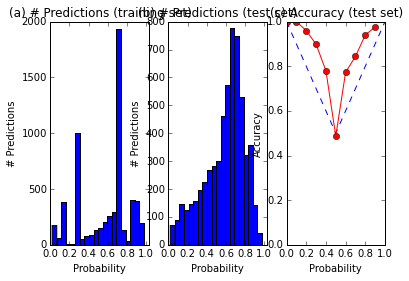

Test set size:	5958
----------------------------------------
Pos. class accuracy: 0.946480511926
Neg. class accuracy: 0.610714285714
----------------------------------------
Precision:	0.768358913813
Recall:		0.946480511926
F1 Score:	0.848168903949
----------------------------------------
TP: 3254 | FP: 981 | TN: 1539 | FN: 184
Recall-corrected Noise-aware Model
Pos. class accuracy: 0.766729500471
Neg. class accuracy: 0.610714285714
Corpus Precision 0.768
Corpus Recall    0.767
Corpus F1        0.768
----------------------------------------
TP: 3254 | FP: 981 | TN: 1539 | FN: 990



In [33]:
tp, fp, tn, fn = disc_model.score(F_dev, L_gold_dev, gold_dev_set)

## Viewing Examples
After evaluating on the development `CandidateSet`, the labeling functions can be modified. Try changing the labeling functions to improve performance. You can view the true positives, false positives, true negatives, and false negatives using the `Viewer`.

In [34]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(tp, session, annotator_name="Tutorial Part IV User")
else:
    sv = None

<IPython.core.display.Javascript object>

In [35]:
sv

Next, in Part V, we will test our model on the test `CandidateSet`.